## Microbenchmarks - Individual

Adapted from https://github.com/TheSalon/fast-dpsgd/blob/main/results/runtimes.ipynb

In [1]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_rows', 200)
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [3]:
RAW = 'raw'
RUNS = 100
REPEATS = 25

# plot memory in MB, otherwise GB
MB = True

# the ratio (currently 2:1) should be the same as for the other graphs
# arbitrary rescaling ok
FIGSIZE = (7, 3.5)

DESAT = 0.35

In [4]:
layers = ['mha', 'rnn', 'gru', 'lstm']

filenames = ['conv', 'layernorm', 'instancenorm', 'groupnorm', 'linear', 'embedding'] + layers
layer_types = ['torch.nn', 'DPModel', 'GSM(DPModel)', 'GSM(Model)']
prefixes = ['', 'dp', 'gsm_dp', 'gsm_']

batch_sizes = [16, 32, 64, 128, 256, 512]
list(zip(prefixes, layer_types))

[('', 'torch.nn'),
 ('dp', 'DPModel'),
 ('gsm_dp', 'GSM(DPModel)'),
 ('gsm_', 'GSM(Model)')]

In [5]:
def expt_iterator():
    for filename in filenames:
        for bs in batch_sizes:
            for prefix, name in zip(prefixes, layer_types):
                if filename in layers and prefix !='gsm_':
                    yield filename, bs, prefix, name
                elif filename not in layers and 'dp' not in prefix:
                    yield filename, bs, prefix, name

files, success, errors = [], [], []
    
for filename, bs, prefix, name in expt_iterator():
    pickle_name = f'./{RAW}/{prefix}{filename}_bs_{bs}_runs_{RUNS}_repeats_{REPEATS}'
    try:
        with open(pickle_name + '.pkl', 'rb') as f:
            d = pickle.load(f)
            assert(len(d['runtime']) == RUNS)
            assert(len(d['memory']) == RUNS)
        files.append((filename, name, bs, d))
        success.append(pickle_name)

    except:
        errors.append(pickle_name)

assert(len(errors) == 0)

df_list = []

for *row, d in files:
    # d['memory'] = (base_memory, max_memory) in GB
    mem = [(m-b)*1000 for b,m in d['memory']] if MB else [(m-b)*100 for b,m in d['memory']]
    # append each run separately so we can get SD
    for runtime, memory in zip(d['runtime'], mem):
        df_list.append(pd.Series(row + [runtime, memory]))

df = pd.concat(df_list, axis=1).transpose()
df.columns = ['Filename', 'Layer Type', 'Batch Size', 'Runtime', 'Memory']
df['Runtime'] = df['Runtime'].astype(float)
df['Memory'] = df['Memory'].astype(float)

In [6]:
df['Order'] = -1
for i, name in enumerate(layer_types):
    df.loc[df['Layer Type'] == name, 'Order'] = i
    
assert not (df['Order'] == -1).sum()
df = df.sort_values(by=['Order', 'Batch Size'])
df

,Filename,Layer Type,Batch Size,Runtime,Memory,Order
0,conv,torch.nn,16,2.659398,739.501056,0
1,conv,torch.nn,16,2.673783,739.501056,0
2,conv,torch.nn,16,2.664355,739.501056,0
3,conv,torch.nn,16,2.681082,739.501056,0
4,conv,torch.nn,16,2.673917,739.501056,0
...,...,...,...,...,...,...
7195,embedding,GSM(Model),512,12.381286,8216.824320,3
7196,embedding,GSM(Model),512,12.391408,8216.824320,3
7197,embedding,GSM(Model),512,12.381275,8216.824320,3
7198,embedding,GSM(Model),512,12.390562,8216.824320,3


In [7]:
def get_runtime_plot(ax, filename, df, statistic='Runtime', ylim=None, figsize=(13, 6)): 
    df = df[['Filename', 'Layer Type', 'Batch Size', statistic, 'Order']].copy()
    
    means = df.groupby(['Filename', 'Layer Type', 'Batch Size', 'Order']).agg('mean').reset_index()
    means.columns = ['Filename', 'Layer Type', 'Batch Size', 'Order', statistic]
    means = means.sort_values(by=['Order', 'Batch Size'])

    std = df.groupby(['Filename', 'Layer Type', 'Batch Size', 'Order']).agg('std').reset_index()
    std.columns = ['Filename', 'Layer Type', 'Batch Size', 'Order', statistic]
    std = std.sort_values(by=['Order', 'Batch Size'])
    
    sns.set_style("whitegrid")
    plot_df = df[df['Filename'] == filename].copy()
    
    # color scheme
    count = len(pd.unique(plot_df['Layer Type']))
    PALETTE = sns.color_palette(palette='Blues', n_colors=6, desat=None, as_cmap=False)[1:]
    reds = sns.color_palette(palette='Reds', n_colors=6, desat=DESAT, as_cmap=False)[1:]
    PALETTE[0] = reds[0]

    if count == 3:
        PALETTE[1] = reds[1]
    
    sns.barplot(
        x='Batch Size', 
        y=statistic, 
        hue='Layer Type', 
        ci='sd', capsize=.07, errwidth=1.,
        data=plot_df, 
        ax=ax, 
        palette=PALETTE
    )
    
    WIDTH = 0.15
    
    tmp = means.loc[(means['Filename'] == filename), statistic]
    std_tmp = std.loc[(std['Filename'] == filename), statistic]
    
    for i, (rect, tim, std_tim) in enumerate(zip(ax.patches, tmp, std_tmp)):
        
        # add space between bars
        width = rect.get_width()
        rect.set_width(width-(width*0.15))
        (x, y) = rect.get_xy()
        rect.set_xy((x + width*0.15, y))

        # annotate bars
        height = rect.get_height()
        width = rect.get_width()
        if tim > 100.:
            annotation = f'{int(tim)}'
        elif tim > 0.:
            annotation = f'{tim:.2g}'
        else:
            annotation = ''
        ax.annotate(
            annotation,
            xy=(
                rect.get_x() + width/2 - 0.5*width, 
                min(height + std_tim, ylim)
            ),
            xytext=(
                rect.get_x() + width/2 - 0.5*width, 
                min(height + std_tim + ylim/figsize[1]*0.08, ylim+ ylim/figsize[1]*0.08)
            ),
            textcoords='data',
            va='bottom', ha='left', 
            fontsize=11, rotation=45)

    ax.set_xlabel('Batch Size')
    if statistic == 'Memory':
        if MB: ax.set_ylabel('Memory (MB)')
        else: ax.set_ylabel('Memory (GB)')       
    else:
        ax.set_ylabel('Runtime (ms)')
    if ylim:
        ax.set_ylim(0, ylim)
    sns.despine()
    ax.legend(loc='upper left')
    f.patch.set_facecolor('white')
    f.tight_layout()
    return f, ax

In [10]:
# def get_fig(layer, runtime_lim, memory_lim, save=False):
#     f, ax = plt.subplots(2, 1, figsize=FIGSIZE, sharey=False)
#     f, ax0 = get_runtime_plot(ax[0], layer, df, 'Runtime', runtime_lim, figsize=FIGSIZE)
#     f, ax1 = get_runtime_plot(ax[1], layer, df, 'Memory', memory_lim, figsize=FIGSIZE)
#     if save:
#         f.savefig(f'./figures/dp{layer}.pdf')
#     return f, ax

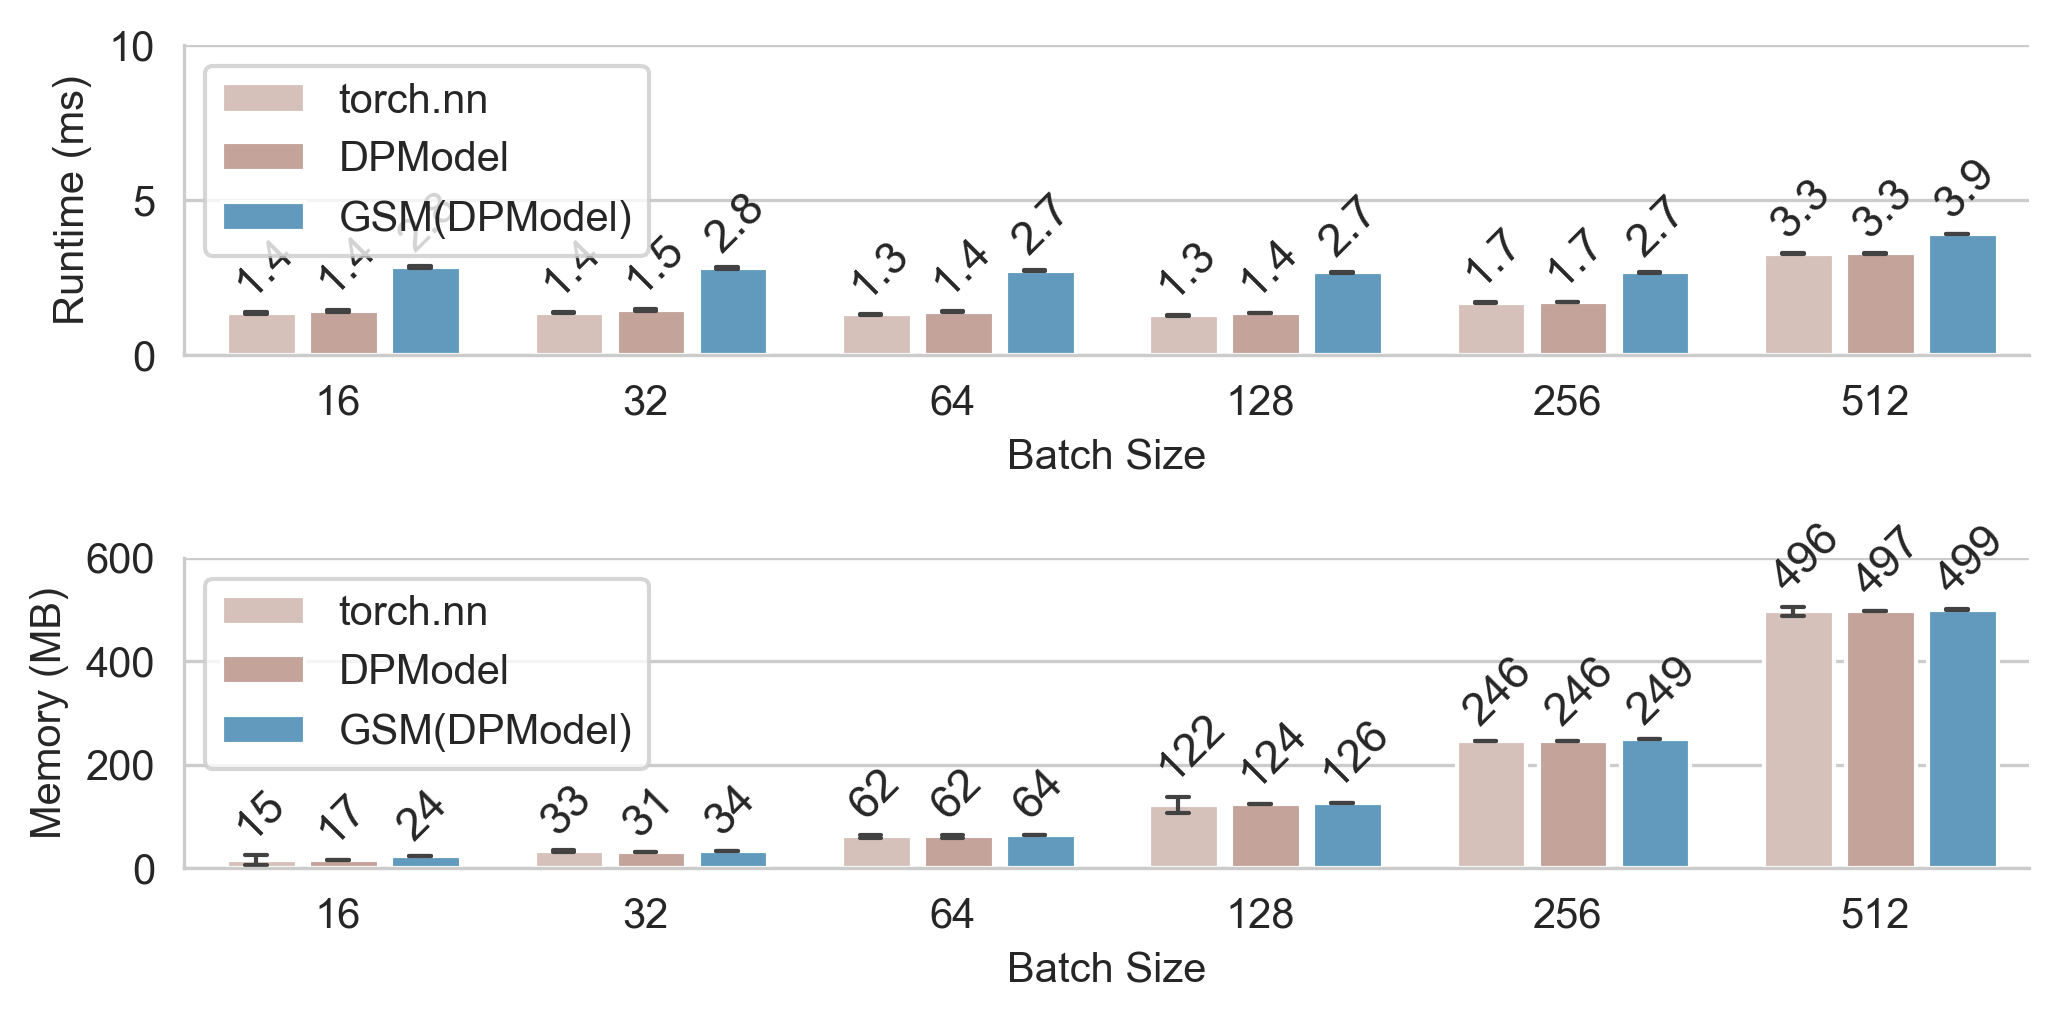

In [12]:
f, ax = plt.subplots(2, 1, figsize=FIGSIZE, sharey=False)
f, ax0 = get_runtime_plot(ax[0], 'mha', df, 'Runtime', 10, figsize=FIGSIZE)
f, ax1 = get_runtime_plot(ax[1], 'mha', df, 'Memory', 600, figsize=FIGSIZE)
f.savefig('./figures/dpmha.pdf')

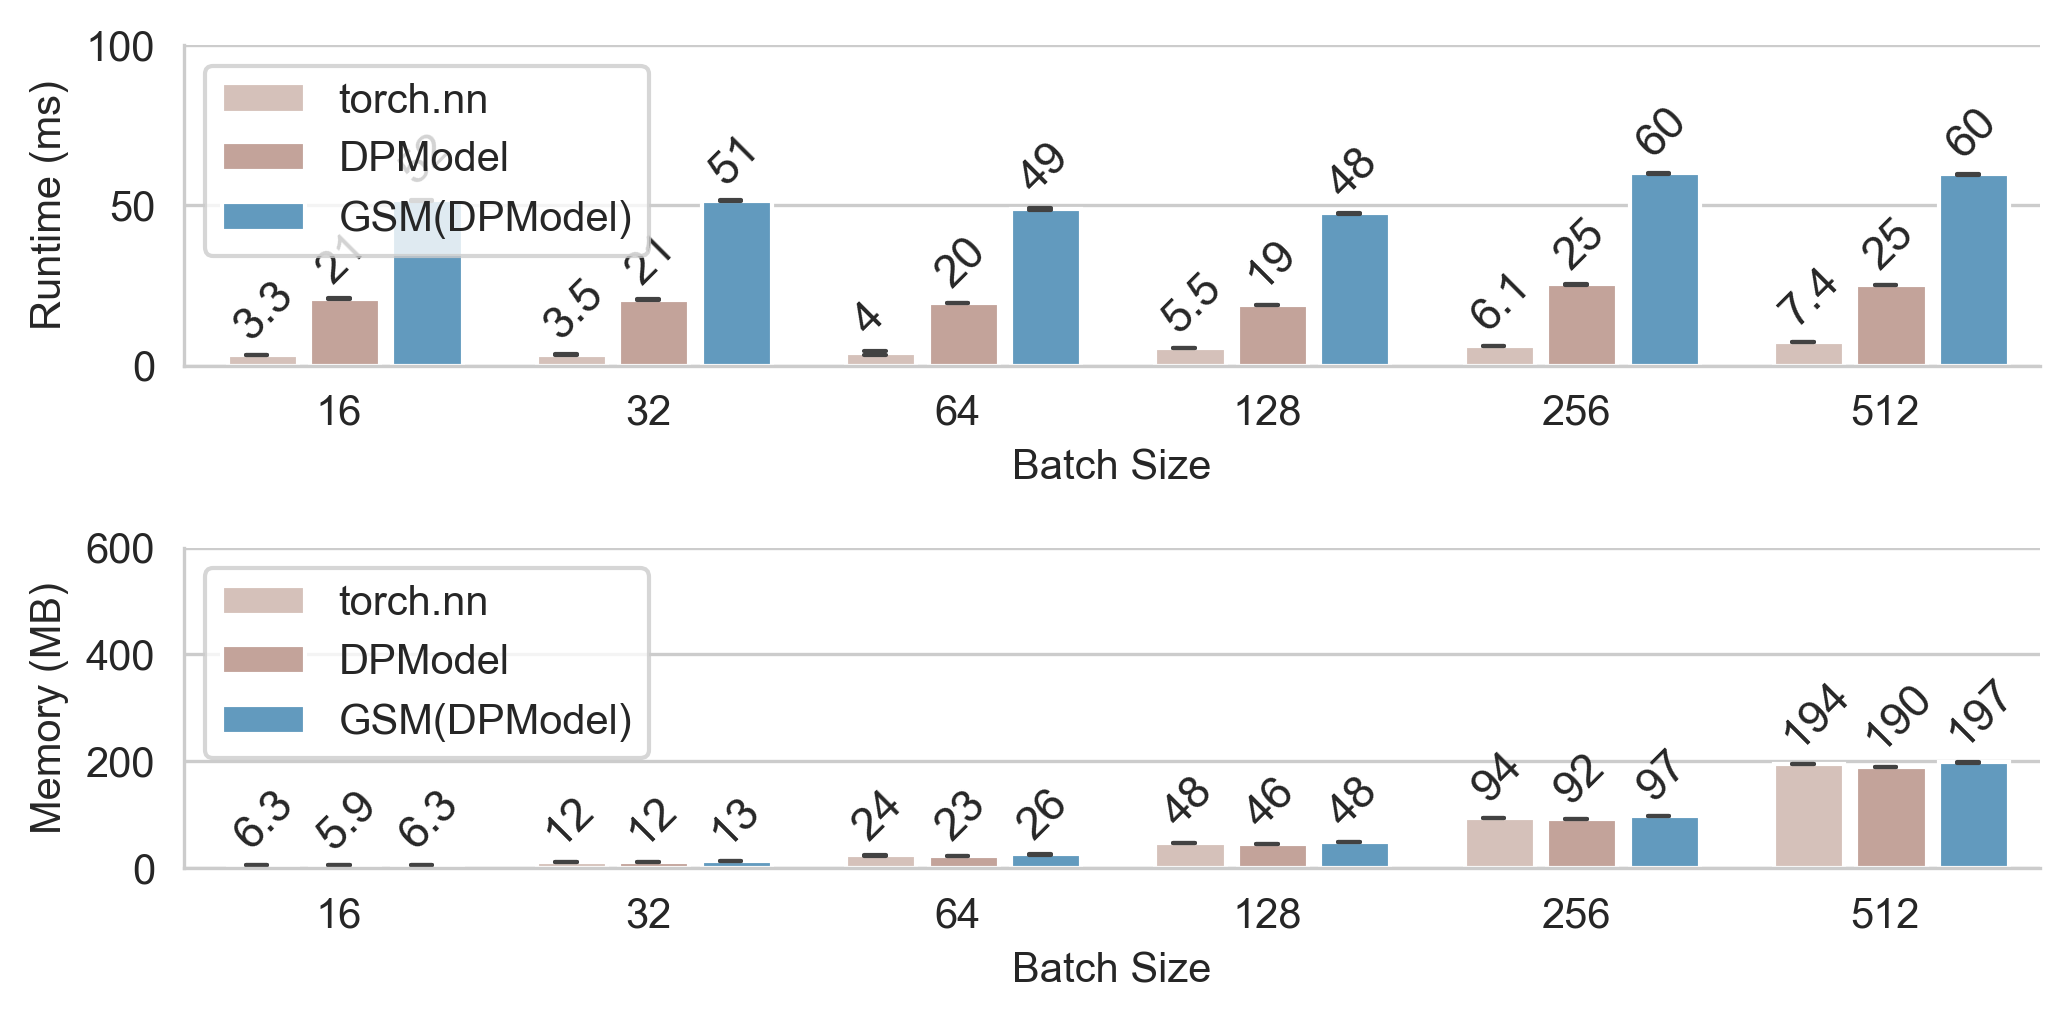

In [13]:
f, ax = plt.subplots(2, 1, figsize=FIGSIZE, sharey=False)
f, ax0 = get_runtime_plot(ax[0], 'rnn', df, 'Runtime', 100, figsize=FIGSIZE)
f, ax1 = get_runtime_plot(ax[1], 'rnn', df, 'Memory', 600, figsize=FIGSIZE)
f.savefig('./figures/dprnn.pdf')

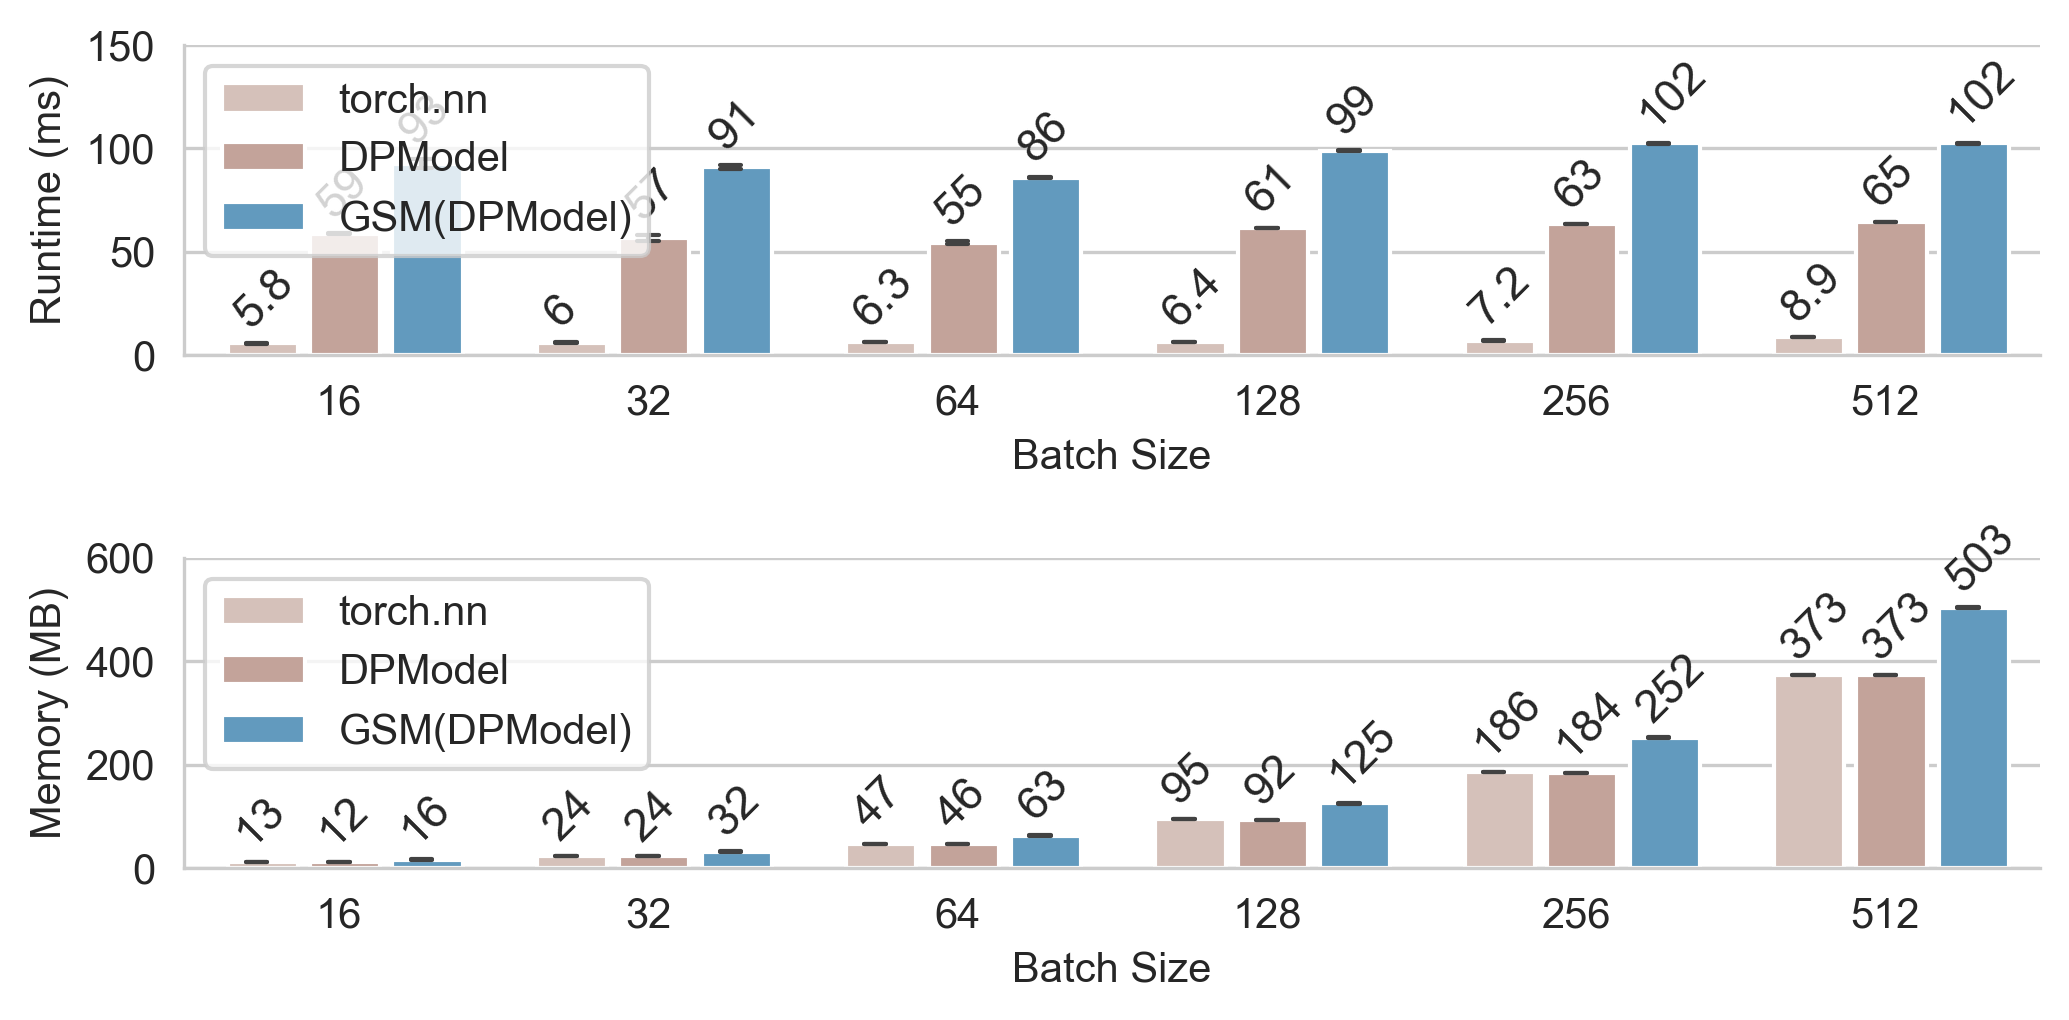

In [14]:
f, ax = plt.subplots(2, 1, figsize=FIGSIZE, sharey=False)
f, ax0 = get_runtime_plot(ax[0], 'gru', df, 'Runtime', 150, figsize=FIGSIZE)
f, ax1 = get_runtime_plot(ax[1], 'gru', df, 'Memory', 600, figsize=FIGSIZE)
f.savefig('./figures/dpgru.pdf')

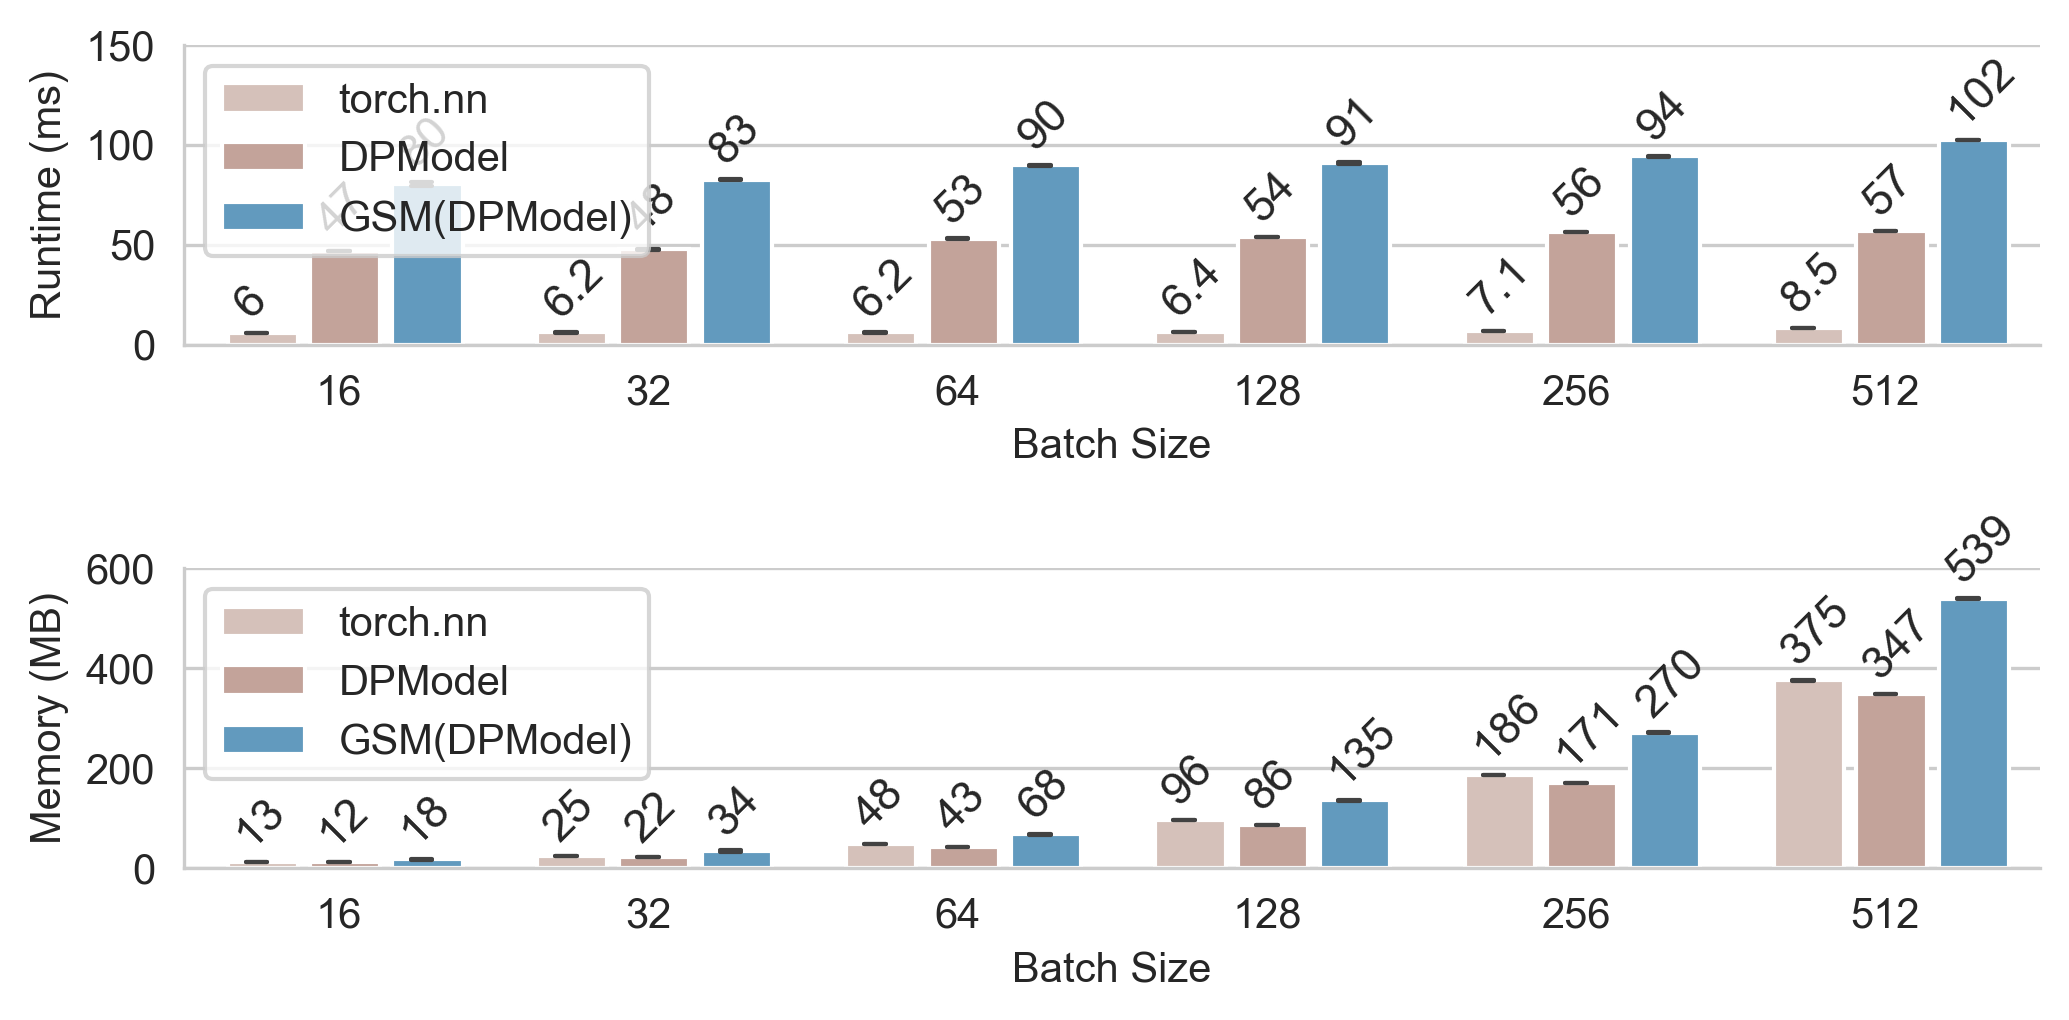

In [15]:
f, ax = plt.subplots(2, 1, figsize=FIGSIZE, sharey=False)
f, ax0 = get_runtime_plot(ax[0], 'lstm', df, 'Runtime', 150, figsize=FIGSIZE)
f, ax1 = get_runtime_plot(ax[1], 'lstm', df, 'Memory', 600, figsize=FIGSIZE)
f.savefig('./figures/dplstm.pdf')

In [ ]:
# f, ax = plt.subplots(2, 1, figsize=FIGSIZE, sharey=False)
# f, ax0 = get_runtime_plot(ax[0], 'embedding', df, 'Runtime', 10, figsize=FIGSIZE)
# f, ax1 = get_runtime_plot(ax[1], 'embedding', df, 'Memory', 10000, figsize=FIGSIZE)